# Impedance Matching: Practical Design Examples at 1 GHz

This notebook demonstrates practical impedance matching techniques using:
1. Transmission line transformations
2. Series reactive elements (inductors/capacitors)
3. Shunt reactive elements (inductors/capacitors)

All examples use **f = 1 GHz** and **Z₀ = 50Ω** transmission lines.

| Technique | Elements | Advantages | Disadvantages | Best For |
|-----------|----------|------------|---------------|----------|
| **Quarter-Wave** | 1 TL (λ/4) | Simple, no lumped elements | Only for resistive loads, narrowband | Resistive impedance transformation |
| **Series Stub** | 1 TL + 1 Series | Simple, 2 elements | Requires specific TL length | General matching, easy to implement |
| **Shunt Stub** | 1 TL + 1 Shunt | Common in microstrip | Requires specific TL length | Microstrip circuits |
| **L-Network** | 2 Lumped | No TL needed, broadband | Limited Q range | Low frequency, broadband |
| **Double-Stub** | 2 Shunt + 1 TL | Tunable stubs | More complex | Tunable matching systems |

## Key Formulas

**Reactance to Inductance:**
$$L = \frac{X_L}{\omega} = \frac{X_L}{2\pi f}$$

**Reactance to Capacitance:**
$$C = \frac{1}{\omega |X_C|} = \frac{1}{2\pi f |X_C|}$$

**Wavelength:**
$$\lambda = \frac{c}{f} = \frac{3 \times 10^8 \text{ m/s}}{f}$$

**VSWR:**
$$\text{VSWR} = \frac{1 + |\Gamma|}{1 - |\Gamma|}$$

where $\Gamma = \frac{Z_L - Z_0}{Z_L + Z_0}$

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

from pysmithchart import utils
from pysmithchart.constants import IMPEDANCE_DOMAIN

# Constants
f = 1e9  # 1 GHz
omega = 2 * np.pi * f
Z0 = 50  # Characteristic impedance

## Helper Functions

In [26]:
def reactance_to_component(X, freq):
    """
    Convert reactance to component value (L or C).

    Args:
        X: Reactance in Ohms (positive for inductor, negative for capacitor)
        freq: Frequency in Hz

    Returns:
        (component_type, value, unit)
    """
    omega = 2 * np.pi * freq

    if X > 0:
        # Inductor: X = ωL → L = X/ω
        L = X / omega
        if L >= 1e-6:
            return ("Inductor", L * 1e6, "µH")
        else:
            return ("Inductor", L * 1e9, "nH")
    elif X < 0:
        # Capacitor: X = -1/(ωC) → C = -1/(ωX)
        C = -1 / (omega * X)
        if C >= 1e-9:
            return ("Capacitor", C * 1e9, "nF")
        else:
            return ("Capacitor", C * 1e12, "pF")
    else:
        return ("None", 0, "")


def draw_block_diagram(ax, components, title):
    """
    Draw a simple block diagram of the matching network.

    Args:
        ax: Matplotlib axes
        components: List of (type, value_str, position) tuples
        title: Title for the diagram
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4)
    ax.axis("off")

    # Draw transmission line
    y_line = 2
    x_pos = 1

    # Source box
    source_box = FancyBboxPatch(
        (0.2, y_line - 0.3), 0.6, 0.6, boxstyle="round,pad=0.05", edgecolor="black", facecolor="lightblue", linewidth=2
    )
    ax.add_patch(source_box)
    ax.text(0.5, y_line, "Source\n50Ω", ha="center", va="center", fontsize=9, fontweight="bold")

    x_pos = 1.0

    for comp_type, value_str, position in components:
        if comp_type == "TL":
            # Draw transmission line
            ax.plot([x_pos - 0.1, x_pos + 1.4], [y_line, y_line], "k-", linewidth=3)
            ax.plot([x_pos - 0.1, x_pos + 1.4], [y_line + 0.1, y_line + 0.1], "k-", linewidth=3)
            ax.text(
                x_pos + 0.65,
                y_line + 0.5,
                value_str,
                ha="center",
                va="center",
                fontsize=9,
                bbox=dict(facecolor="yellow", alpha=0.8),
            )
            x_pos += 1.5

        elif comp_type == "Series":
            # Draw series element
            ax.plot([x_pos, x_pos + 0.3], [y_line, y_line], "k-", linewidth=2)

            # Component box
            comp_box = Rectangle(
                (x_pos + 0.3, y_line - 0.2), 0.6, 0.4, edgecolor="black", facecolor="orange", linewidth=2
            )
            ax.add_patch(comp_box)
            ax.text(
                x_pos + 0.6, y_line, value_str.split("\n")[0], ha="center", va="center", fontsize=8, fontweight="bold"
            )

            ax.plot([x_pos + 0.9, x_pos + 1.2], [y_line, y_line], "k-", linewidth=2)
            ax.text(
                x_pos + 0.6,
                y_line - 0.6,
                value_str.split("\n")[1] if "\n" in value_str else "",
                ha="center",
                va="center",
                fontsize=7,
            )
            x_pos += 1.2

        elif comp_type == "Shunt":
            # Draw shunt element
            ax.plot([x_pos, x_pos + 0.5], [y_line, y_line], "k-", linewidth=2)
            ax.plot([x_pos + 0.25, x_pos + 0.25], [y_line, y_line - 0.8], "k-", linewidth=2)

            # Component box
            comp_box = Rectangle(
                (x_pos + 0.05, y_line - 1.1), 0.4, 0.3, edgecolor="black", facecolor="lightgreen", linewidth=2
            )
            ax.add_patch(comp_box)
            ax.text(
                x_pos + 0.25,
                y_line - 0.95,
                value_str.split("\n")[0],
                ha="center",
                va="center",
                fontsize=8,
                fontweight="bold",
            )

            # Ground symbol
            ax.plot([x_pos + 0.15, x_pos + 0.35], [y_line - 1.3, y_line - 1.3], "k-", linewidth=3)
            ax.plot([x_pos + 0.18, x_pos + 0.32], [y_line - 1.4, y_line - 1.4], "k-", linewidth=2)
            ax.plot([x_pos + 0.21, x_pos + 0.29], [y_line - 1.5, y_line - 1.5], "k-", linewidth=1)

            ax.text(
                x_pos + 0.25,
                y_line - 1.8,
                value_str.split("\n")[1] if "\n" in value_str else "",
                ha="center",
                va="center",
                fontsize=7,
            )
            x_pos += 0.5

    # Load box
    load_box = FancyBboxPatch(
        (x_pos, y_line - 0.3),
        0.8,
        0.6,
        boxstyle="round,pad=0.05",
        edgecolor="black",
        facecolor="lightcoral",
        linewidth=2,
    )
    ax.add_patch(load_box)
    ax.text(x_pos + 0.4, y_line, "Load\n50Ω", ha="center", va="center", fontsize=9, fontweight="bold")

    ax.set_title(title, fontsize=12, fontweight="bold", pad=10)

## Example 1: Quarter-Wave Transformer

The simplest matching technique: a λ/4 transmission line transforms impedance by Z' = Z₀²/Z.

**Application:** Matching a resistive load to 50Ω line.

EXAMPLE 1: QUARTER-WAVE TRANSFORMER
Frequency: 1.0 GHz
Load impedance: 100.0+0.0j Ω
Transmission line: 0.25λ (90° electrical length)

After λ/4 line: 25.00+0.00j Ω
Expected (Z₀²/Z_load): 25.00+0.00j Ω

Physical line length: 75.0 mm


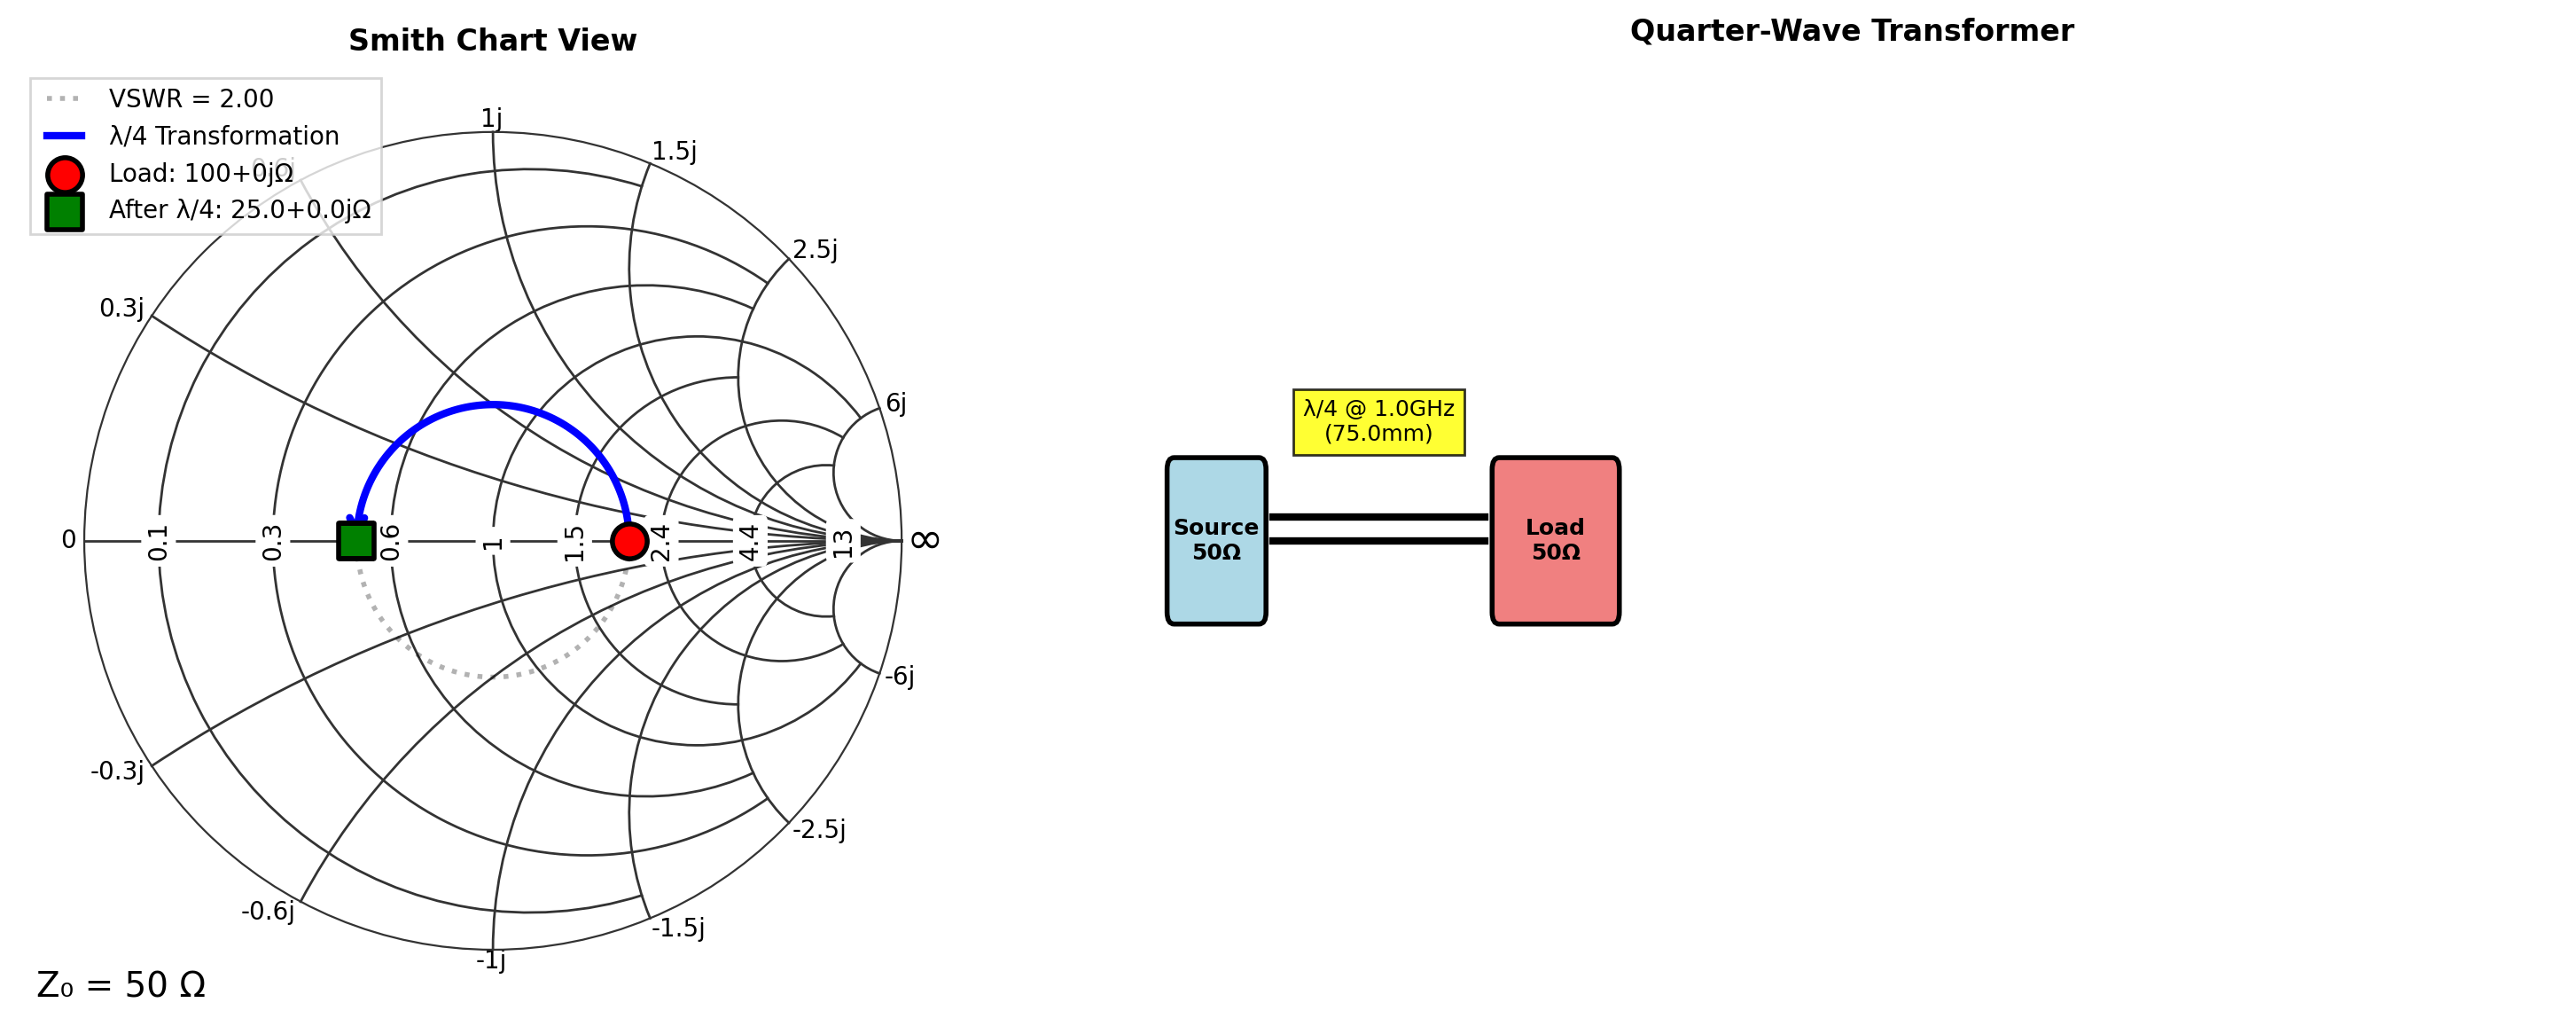

In [27]:
# Example 1: Quarter-wave transformer
Z_load = 100 + 0j  # 100Ω resistive load
wavelength = 0.25  # λ/4

print("=" * 60)
print("EXAMPLE 1: QUARTER-WAVE TRANSFORMER")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: {Z_load:.1f} Ω")
print(f"Transmission line: {wavelength}λ (90° electrical length)")
print()

# Calculate transformed impedance
Z_transformed = utils.rotate_by_wavelength(Z_load, wavelength, Z0=Z0)
print(f"After λ/4 line: {Z_transformed:.2f} Ω")
print(f"Expected (Z₀²/Z_load): {Z0**2/Z_load:.2f} Ω")
print()

# Physical length
c = 3e8  # Speed of light
lambda_m = c / f
length_mm = wavelength * lambda_m * 1000
print(f"Physical line length: {length_mm:.1f} mm")

# Create visualization
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax_smith = fig.add_subplot(gs[0], projection="smith")
ax_diagram = fig.add_subplot(gs[1])

# Smith chart
vswr = utils.calc_vswr(Z0, Z_load)
ax_smith.plot_vswr(vswr, "k:", alpha=0.3, label=f"VSWR = {vswr:.2f}")

# Plot rotation path
ax_smith.plot_rotation_path(Z_load, Z_transformed, "b-", linewidth=3, arrow="end", label="λ/4 Transformation")

# Mark points
ax_smith.scatter(
    Z_load, c="red", s=200, marker="o", edgecolors="black", linewidths=2, label=f"Load: {Z_load:.0f}Ω", zorder=10
)
ax_smith.scatter(
    Z_transformed,
    c="green",
    s=200,
    marker="s",
    edgecolors="black",
    linewidths=2,
    label=f"After λ/4: {Z_transformed:.1f}Ω",
    zorder=10,
)

ax_smith.legend(loc="upper left", fontsize=10)
ax_smith.set_title("Smith Chart View", fontsize=12, fontweight="bold")

# Block diagram
components = [("TL", f"λ/4 @ {f/1e9:.1f}GHz\n({length_mm:.1f}mm)", "between")]
draw_block_diagram(ax_diagram, components, "Quarter-Wave Transformer")

plt.tight_layout()
plt.show()

## Example 2: Single-Stub Matching (Series)

Match a complex load using:
1. Transmission line to rotate to real axis
2. Series reactive element to cancel remaining reactance

**Application:** Simple two-element matching network.

EXAMPLE 2: SERIES STUB MATCHING
Frequency: 1.0 GHz
Load impedance: 75.0+100.0j Ω

Step 1 - After transmission line: 230.84+0.00j Ω
  TL length: 0.9482λ (284.46 mm)

Step 2 - Series element:
  Reactance needed: -0.00 Ω
  Component: None = 0.00 

Final impedance: 230.84+0.00j Ω
Final VSWR: 4.617:1


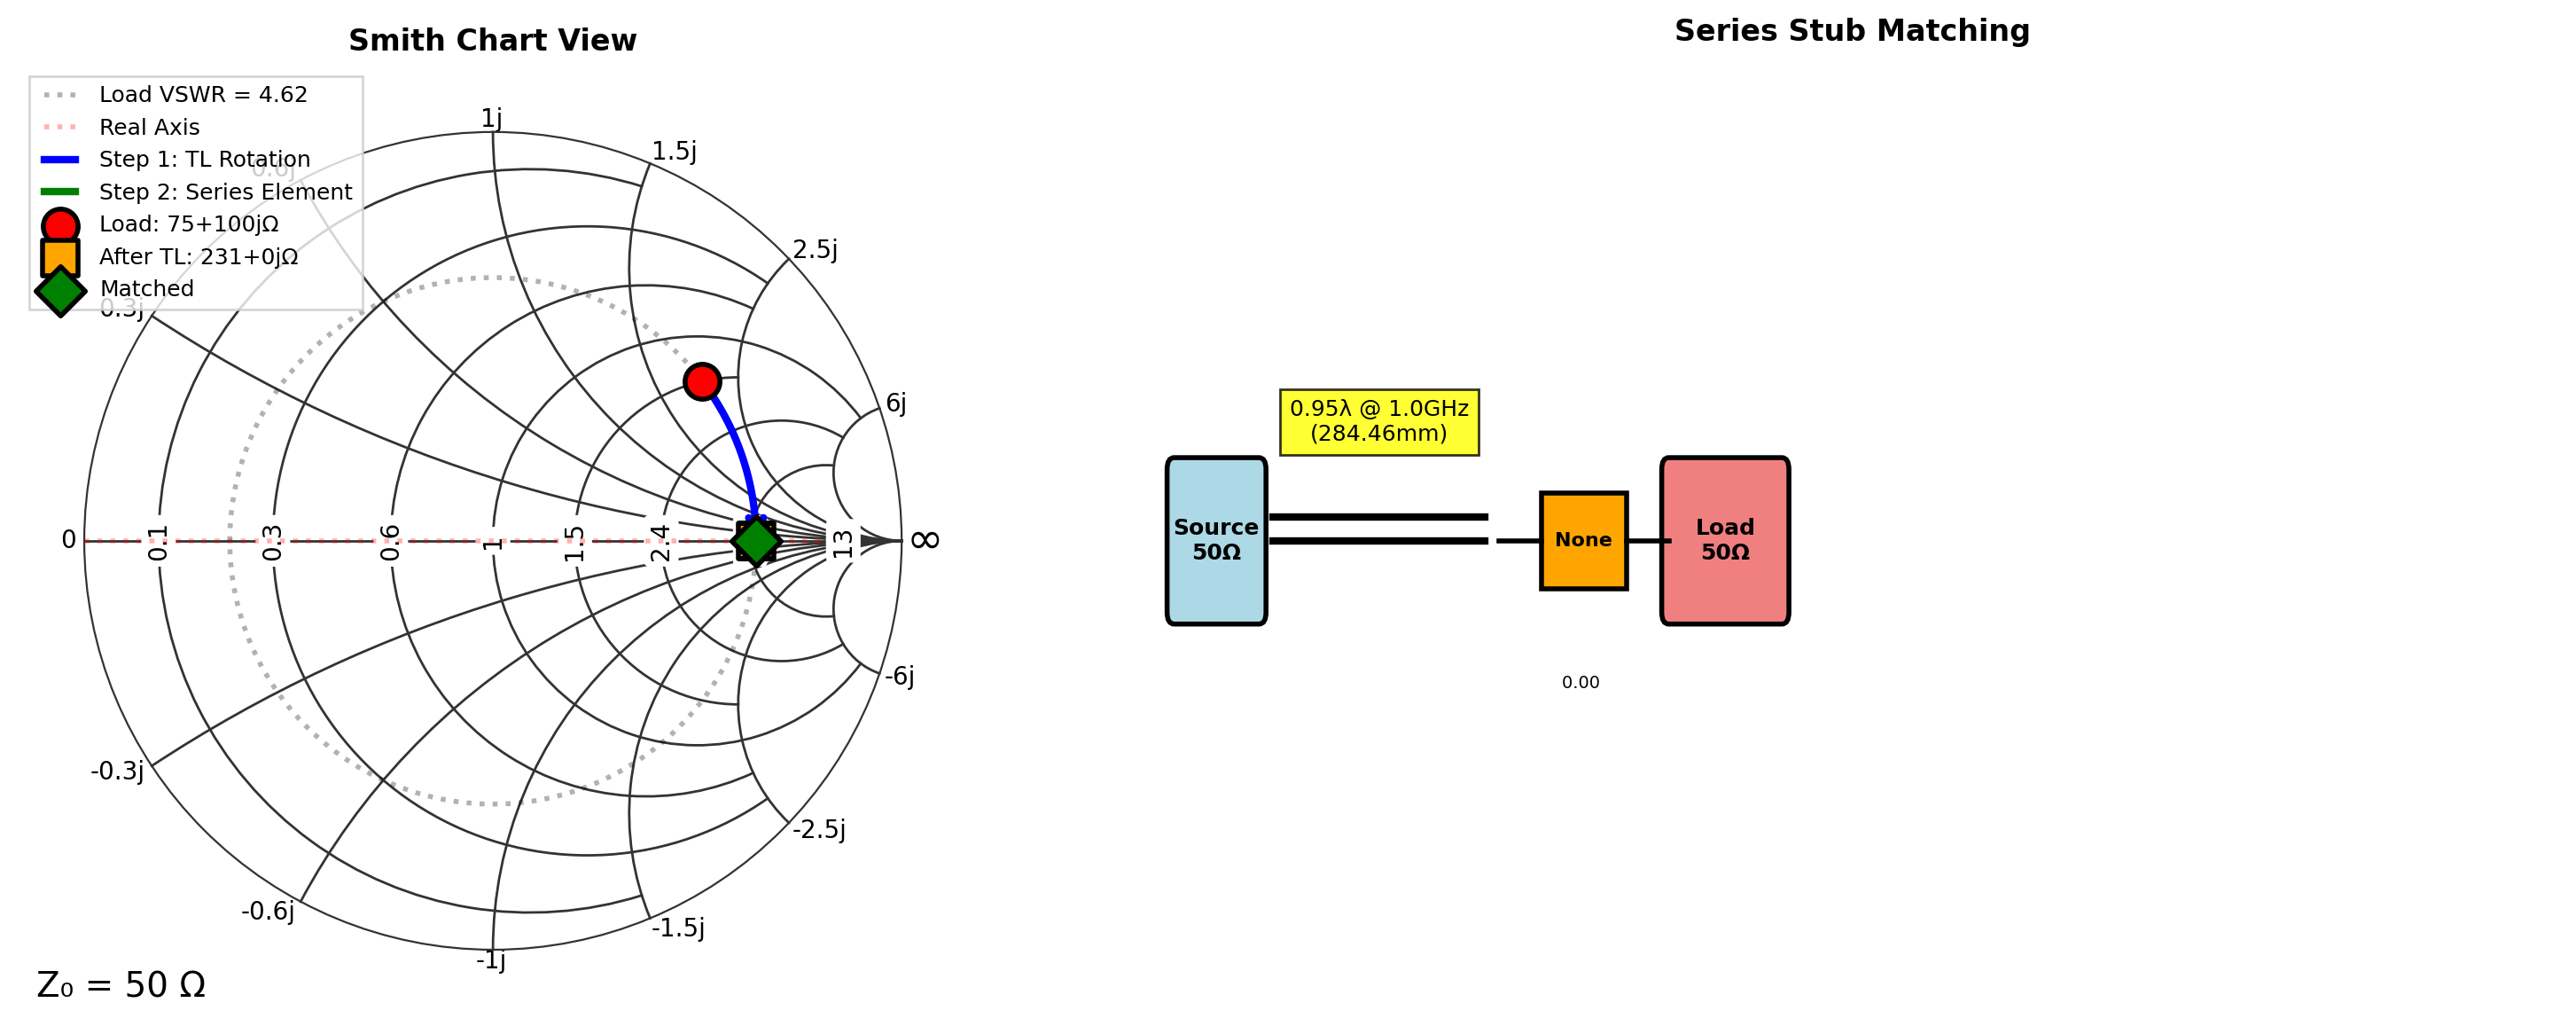

In [30]:
# Example 2: Series stub matching
Z_load = 75 + 100j  # Complex load

print("=" * 60)
print("EXAMPLE 2: SERIES STUB MATCHING")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: {Z_load:.1f} Ω")
print()

# Step 1: Rotate to real axis
Z_after_tl = utils.rotate_toward_imag(Z_load, 0, Z0=Z0, solution="closer")
print(f"Step 1 - After transmission line: {Z_after_tl:.2f} Ω")

# Calculate TL length
gamma_load = (Z_load / Z0 - 1) / (Z_load / Z0 + 1)
gamma_tl = (Z_after_tl / Z0 - 1) / (Z_after_tl / Z0 + 1)
angle_diff = np.angle(gamma_tl) - np.angle(gamma_load)
wavelength_tl = (angle_diff / (4 * np.pi)) % 1
length_tl_mm = wavelength_tl * lambda_m * 1000
print(f"  TL length: {wavelength_tl:.4f}λ ({length_tl_mm:.2f} mm)")
print()

# Step 2: Series reactance to cancel and match to 50Ω
X_series = -Z_after_tl.imag  # Cancel reactance
R_parallel_needed = Z_after_tl.real - Z0  # Additional resistance transformation needed

comp_type, comp_value, comp_unit = reactance_to_component(X_series, f)
print(f"Step 2 - Series element:")
print(f"  Reactance needed: {X_series:+.2f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

# Final impedance
Z_final = Z_after_tl.real + 1j * (Z_after_tl.imag + X_series)
print(f"Final impedance: {Z_final:.2f} Ω")
vswr_final = utils.calc_vswr(Z0, Z_final)
print(f"Final VSWR: {vswr_final:.3f}:1")

# Visualization
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax_smith = fig.add_subplot(gs[0], projection="smith")
ax_diagram = fig.add_subplot(gs[1])

# Smith chart
vswr = utils.calc_vswr(Z0, Z_load)
ax_smith.plot_vswr(vswr, "k:", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")
ax_smith.plot_constant_reactance(0, "r:", alpha=0.3, linewidth=2, label="Real Axis")

# Plot transformations
ax_smith.plot_rotation_path(Z_load, Z_after_tl, "b-", linewidth=3, arrow="end", label="Step 1: TL Rotation")

# Series element (vertical line in impedance)
Z_plot = np.array([Z_after_tl, Z_final])
ax_smith.plot(Z_plot, "g-", linewidth=3, arrow="end", label="Step 2: Series Element")

# Mark points
ax_smith.scatter(
    Z_load, c="red", s=200, marker="o", edgecolors="black", linewidths=2, label=f"Load: {Z_load:.0f}Ω", zorder=10
)
ax_smith.scatter(
    Z_after_tl,
    c="orange",
    s=200,
    marker="s",
    edgecolors="black",
    linewidths=2,
    label=f"After TL: {Z_after_tl:.0f}Ω",
    zorder=10,
)
ax_smith.scatter(Z_final, c="green", s=200, marker="D", edgecolors="black", linewidths=2, label=f"Matched", zorder=10)

ax_smith.legend(loc="upper left", fontsize=9)
ax_smith.set_title("Smith Chart View", fontsize=12, fontweight="bold")

# Block diagram
components = [
    ("TL", f"{wavelength_tl:.2f}λ @ {f/1e9:.1f}GHz\n({length_tl_mm:.2f}mm)", "first"),
    ("Series", f"{comp_type}\n{comp_value:.2f} {comp_unit}", "second"),
]
draw_block_diagram(ax_diagram, components, "Series Stub Matching")

plt.tight_layout()
plt.show()

## Example 3: Single-Stub Matching (Shunt)

Match using:
1. Transmission line to rotate to conductance = 1/Z₀
2. Shunt reactive element to cancel susceptance

**Application:** Common in microstrip circuits where shunt stubs are easier to implement.

EXAMPLE 3: SHUNT STUB MATCHING
Frequency: 1.0 GHz
Load impedance: 100.0+75.0j Ω

Load admittance: 6.400-4.800j mS
Target conductance: 20.000 mS (1/Z₀)

Step 1 - After transmission line:
  Impedance: 50.00+63.74j Ω
  Admittance: 7.619-9.712j mS
  TL length: 0.0385λ (11.56 mm)

Step 2 - Shunt element:
  Susceptance needed: +9.712 mS
  Equivalent reactance: -102.96 Ω
  Component: Capacitor = 1.55 pF

Final impedance: 131.25+0.00j Ω
Final VSWR: 2.625:1


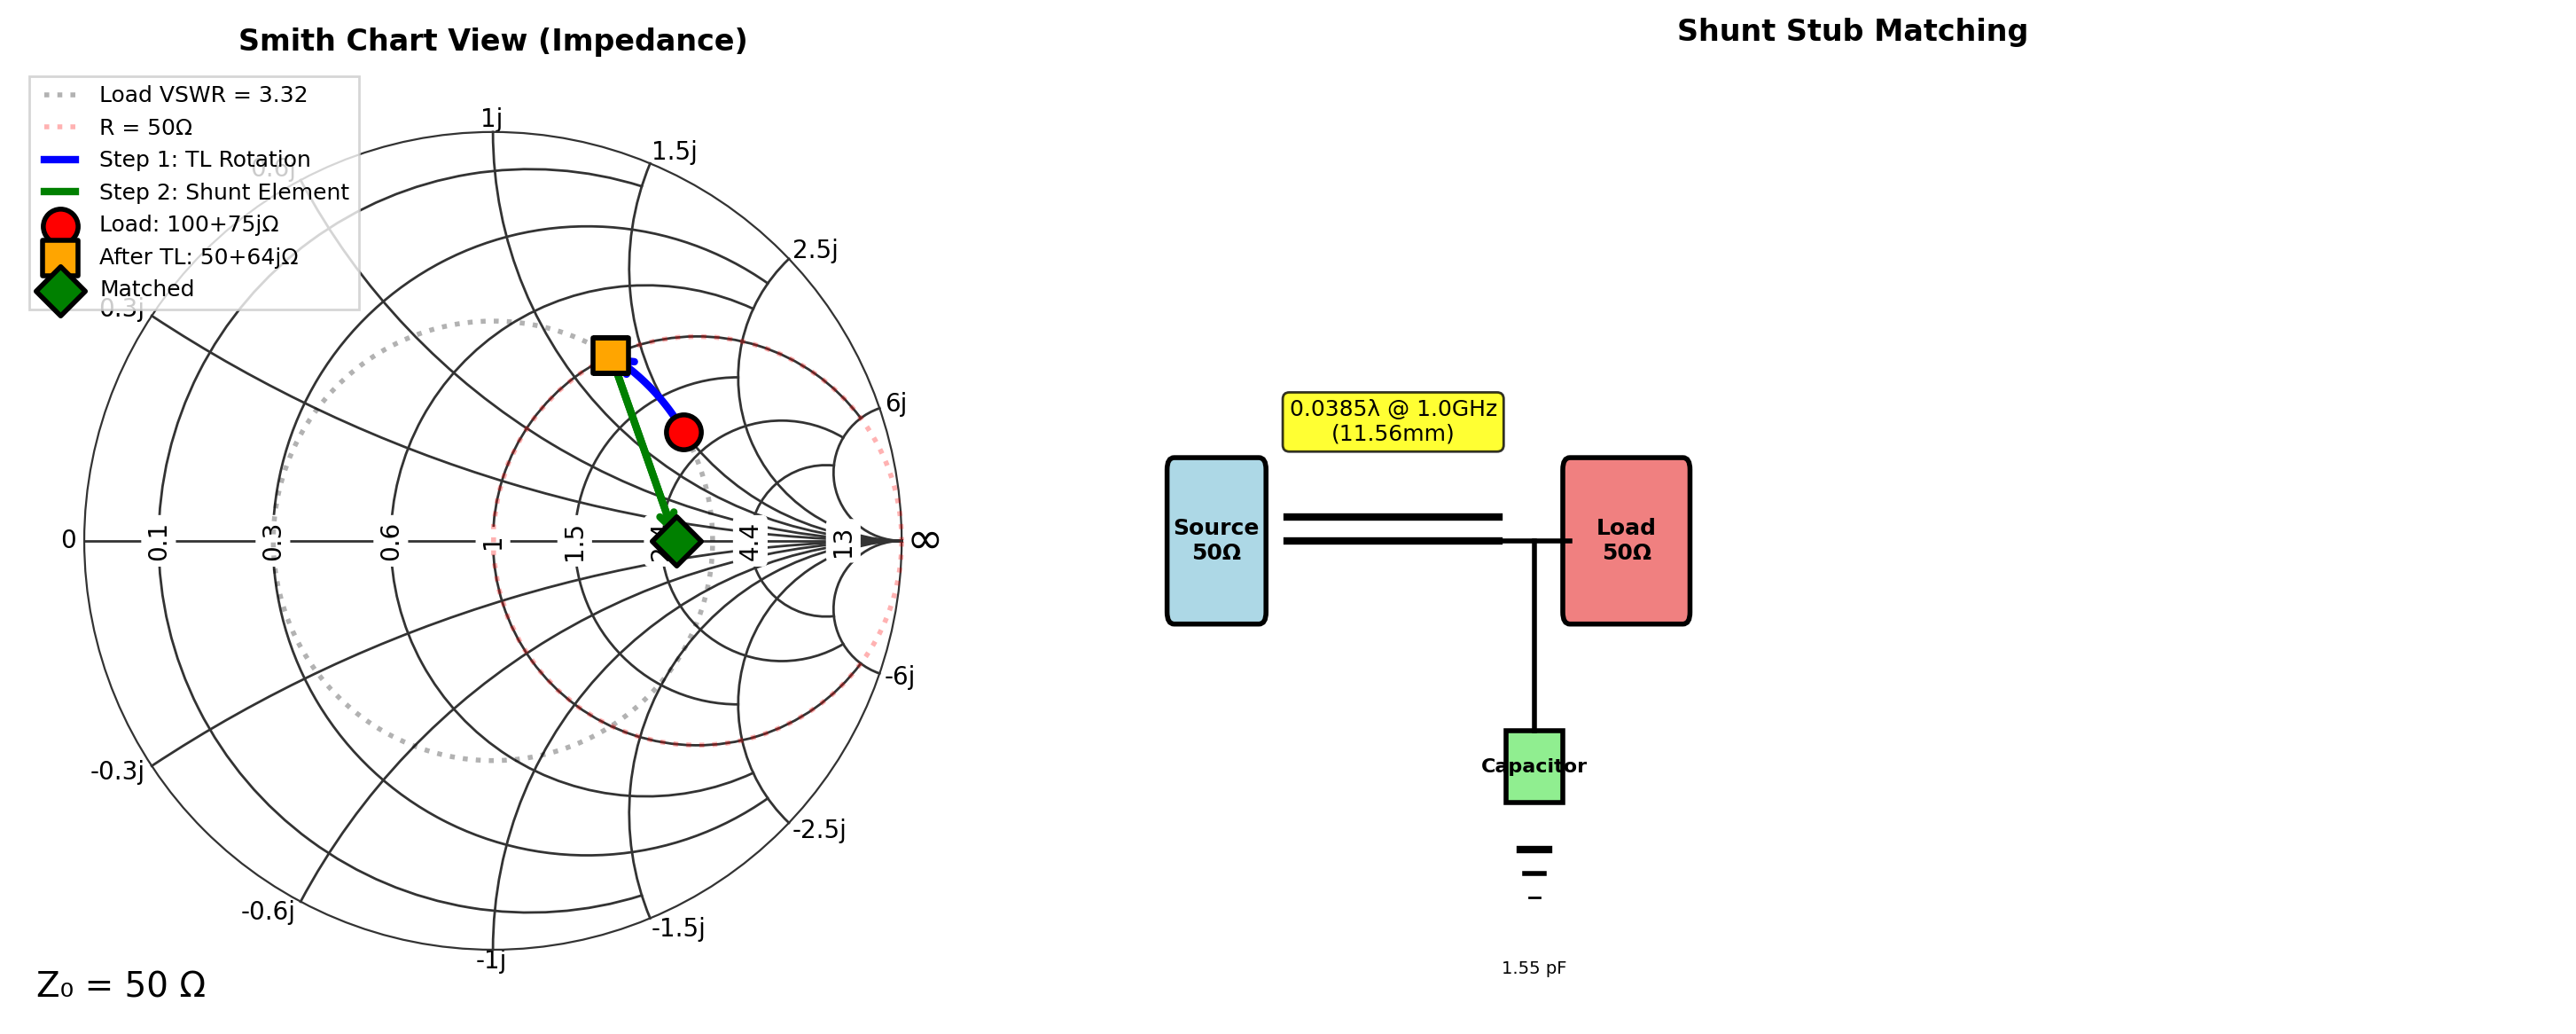

In [5]:
# Example 3: Shunt stub matching
Z_load = 100 + 75j  # Complex load

print("=" * 60)
print("EXAMPLE 3: SHUNT STUB MATCHING")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: {Z_load:.1f} Ω")
print()

# Work in admittance (easier for shunt elements)
Y_load = 1 / Z_load
Y0 = 1 / Z0
print(f"Load admittance: {Y_load*1000:.3f} mS")
print(f"Target conductance: {Y0*1000:.3f} mS (1/Z₀)")
print()

# Step 1: Rotate to G = Y0 (conductance = 1/Z0)
# Convert to impedance for the rotation function
Z_target_G = Z0 + 1j * 0  # We want real part = Z0 after conversion

# Rotate toward real part = Z0 in impedance
Z_after_tl = utils.rotate_toward_real(Z_load, Z0, Z0=Z0, solution="closer")
Y_after_tl = 1 / Z_after_tl

print(f"Step 1 - After transmission line:")
print(f"  Impedance: {Z_after_tl:.2f} Ω")
print(f"  Admittance: {Y_after_tl*1000:.3f} mS")

# Calculate TL length
gamma_load = (Z_load / Z0 - 1) / (Z_load / Z0 + 1)
gamma_tl = (Z_after_tl / Z0 - 1) / (Z_after_tl / Z0 + 1)
angle_diff = np.angle(gamma_tl) - np.angle(gamma_load)
wavelength_tl = (angle_diff / (4 * np.pi)) % 1
length_tl_mm = wavelength_tl * lambda_m * 1000
print(f"  TL length: {wavelength_tl:.4f}λ ({length_tl_mm:.2f} mm)")
print()

# Step 2: Shunt susceptance to cancel
B_shunt = -Y_after_tl.imag  # Susceptance to cancel
X_shunt = -1 / B_shunt if B_shunt != 0 else 0  # Reactance of shunt element

comp_type, comp_value, comp_unit = reactance_to_component(X_shunt, f)
print(f"Step 2 - Shunt element:")
print(f"  Susceptance needed: {B_shunt*1000:+.3f} mS")
print(f"  Equivalent reactance: {X_shunt:+.2f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

# Final admittance
Y_final = Y_after_tl + 1j * B_shunt
Z_final = 1 / Y_final
print(f"Final impedance: {Z_final:.2f} Ω")
vswr_final = utils.calc_vswr(Z0, Z_final)
print(f"Final VSWR: {vswr_final:.3f}:1")

# Visualization
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax_smith = fig.add_subplot(gs[0], projection="smith")
ax_diagram = fig.add_subplot(gs[1])

# Smith chart
vswr = utils.calc_vswr(Z0, Z_load)
ax_smith.plot_vswr(vswr, "k:", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")
ax_smith.plot_constant_resistance(Z0, "r:", alpha=0.3, linewidth=2, label=f"R = {Z0}Ω")

# Plot transformations
ax_smith.plot_rotation_path(Z_load, Z_after_tl, "b-", linewidth=3, arrow="end", label="Step 1: TL Rotation")

# Shunt element (horizontal move in admittance = circular arc in impedance)
# For visualization, draw straight line (approximate)
Z_plot = np.array([Z_after_tl, Z_final])
ax_smith.plot(Z_plot, "g-", linewidth=3, arrow="end", label="Step 2: Shunt Element")

# Mark points
ax_smith.scatter(
    Z_load, c="red", s=200, marker="o", edgecolors="black", linewidths=2, label=f"Load: {Z_load:.0f}Ω", zorder=10
)
ax_smith.scatter(
    Z_after_tl,
    c="orange",
    s=200,
    marker="s",
    edgecolors="black",
    linewidths=2,
    label=f"After TL: {Z_after_tl:.0f}Ω",
    zorder=10,
)
ax_smith.scatter(Z_final, c="green", s=200, marker="D", edgecolors="black", linewidths=2, label=f"Matched", zorder=10)

ax_smith.legend(loc="upper left", fontsize=9)
ax_smith.set_title("Smith Chart View (Impedance)", fontsize=12, fontweight="bold")

# Block diagram
components = [
    ("TL", f"{wavelength_tl:.4f}λ @ {f/1e9:.1f}GHz\n({length_tl_mm:.2f}mm)", "first"),
    ("Shunt", f"{comp_type}\n{comp_value:.2f} {comp_unit}", "second"),
]
draw_block_diagram(ax_diagram, components, "Shunt Stub Matching")

plt.tight_layout()
plt.show()

## Example 4: L-Network Matching (Series-Shunt)

Two-element L-network using:
1. Series reactive element
2. Shunt reactive element

**Application:** Broadband matching without transmission lines (good for low frequencies).

EXAMPLE 4: L-NETWORK MATCHING (SERIES-SHUNT)
Frequency: 1.0 GHz
Load impedance: 25.0+40.0j Ω

Configuration: Series-Shunt (R_load < Z₀)
Quality factor Q: 1.000

Series element:
  Reactance: -15.00 Ω
  Component: Capacitor = 10.61 pF

Shunt element:
  Reactance: +100.00 Ω
  Component: Inductor = 15.92 nH

After series element: 25.00+25.00j Ω
Final impedance: 15.38+23.08j Ω
Final VSWR: 4.000:1


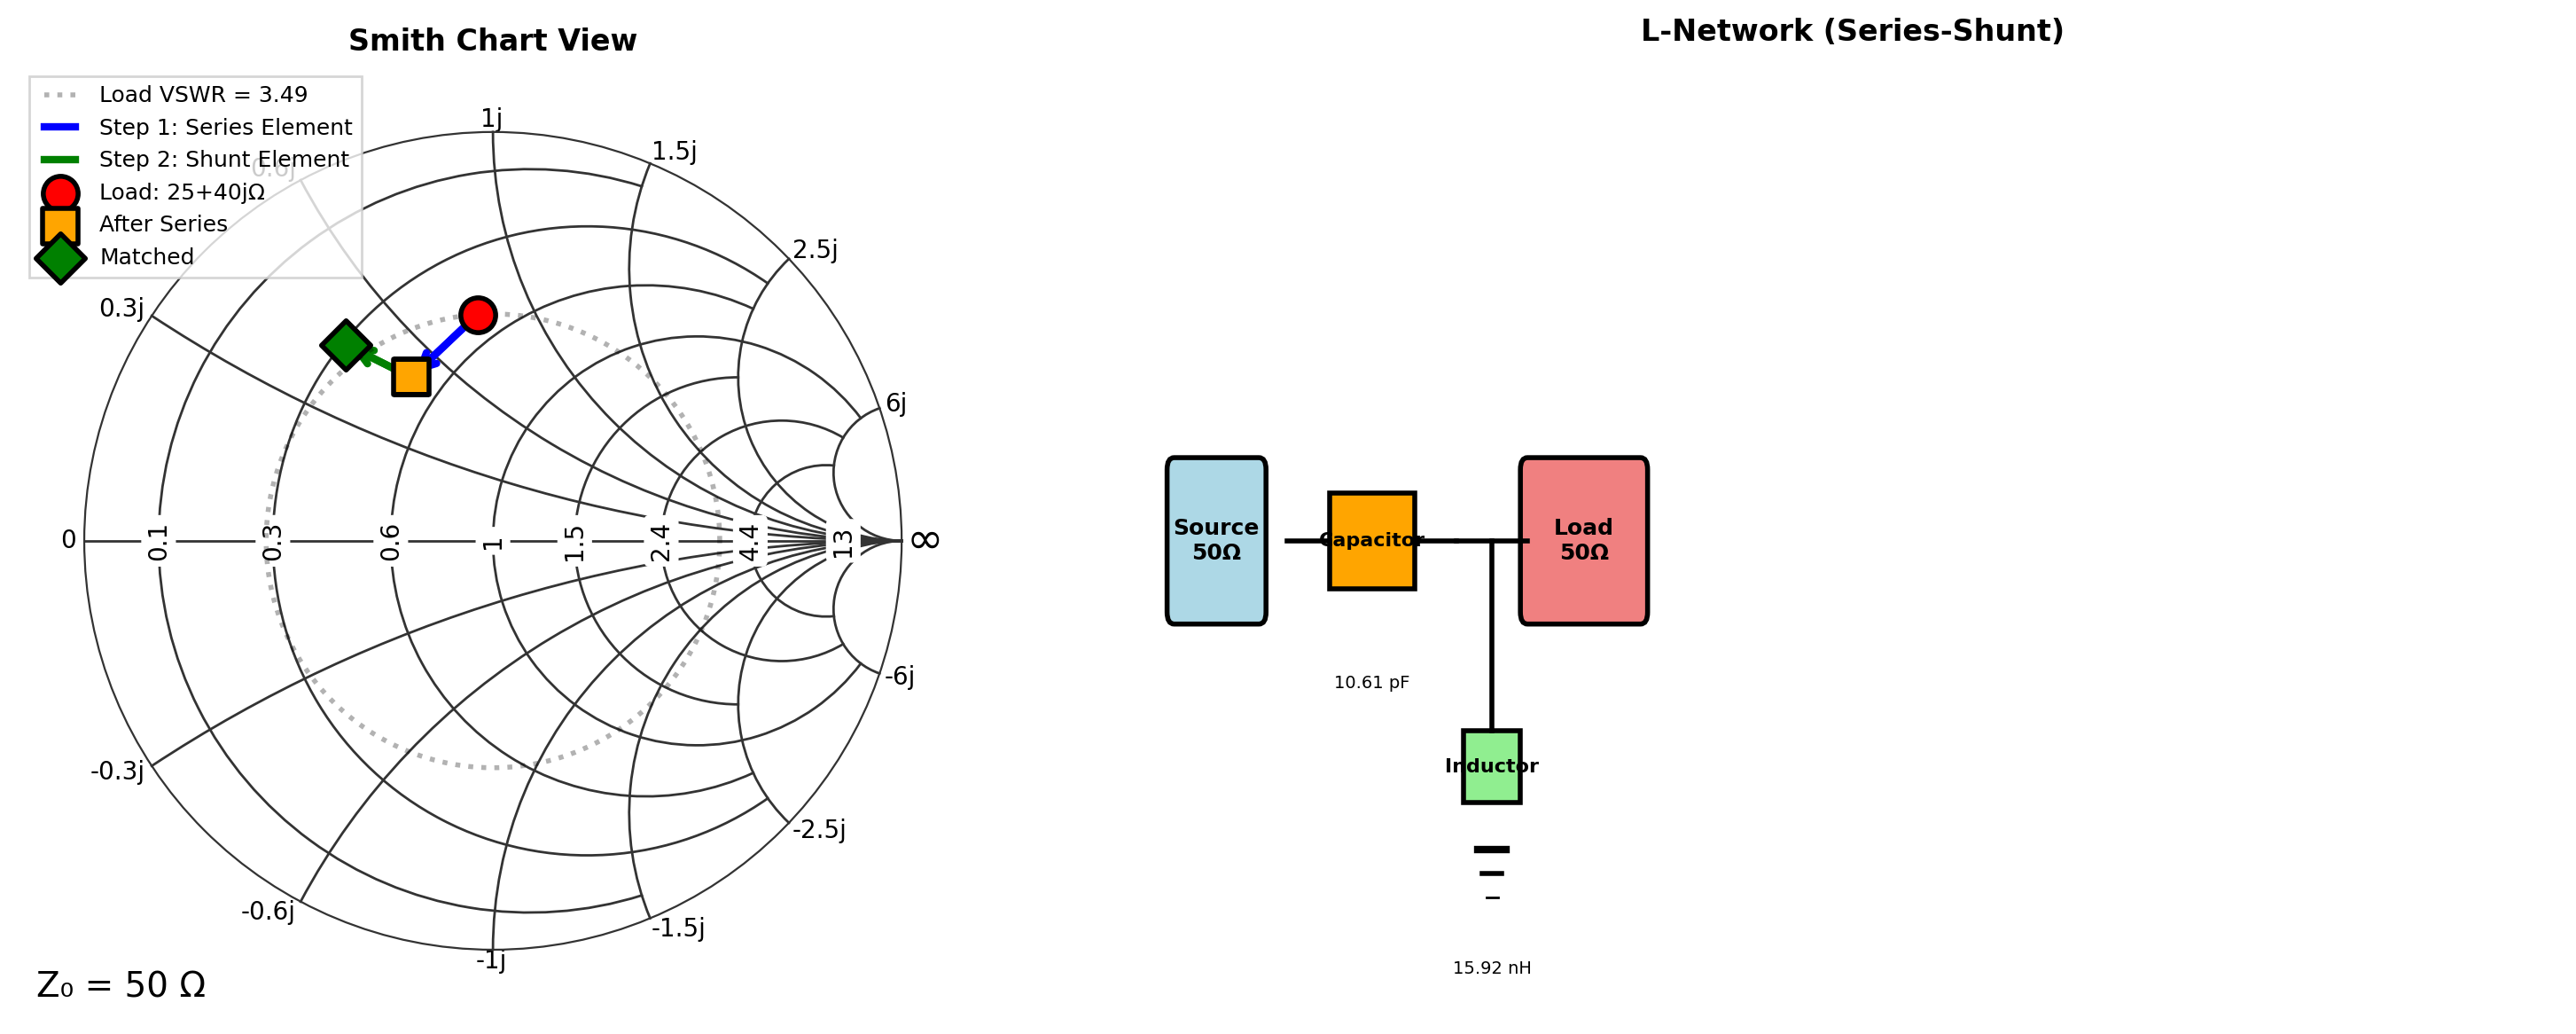

In [6]:
# Example 4: L-Network (Series-Shunt)
Z_load = 25 + 40j  # Low-R, high-X load

print("=" * 60)
print("EXAMPLE 4: L-NETWORK MATCHING (SERIES-SHUNT)")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: {Z_load:.1f} Ω")
print()

# L-network design formulas
R_load = Z_load.real
X_load = Z_load.imag

# For R_load < Z0, use series element first
if R_load < Z0:
    # Series reactance
    Q = np.sqrt(Z0 / R_load - 1)
    X_series = -X_load + Q * R_load

    # Shunt reactance
    X_shunt = Z0 * (1 + Q**2) / Q

    print(f"Configuration: Series-Shunt (R_load < Z₀)")
    print(f"Quality factor Q: {Q:.3f}")
    print()
else:
    # For R_load > Z0, use shunt element first
    Q = np.sqrt(R_load / Z0 - 1)
    X_shunt = R_load / Q
    X_series = -X_load - Q * Z0

    print(f"Configuration: Shunt-Series (R_load > Z₀)")
    print(f"Quality factor Q: {Q:.3f}")
    print()

# Component values
comp1_type, comp1_value, comp1_unit = reactance_to_component(X_series, f)
comp2_type, comp2_value, comp2_unit = reactance_to_component(X_shunt, f)

print(f"Series element:")
print(f"  Reactance: {X_series:+.2f} Ω")
print(f"  Component: {comp1_type} = {comp1_value:.2f} {comp1_unit}")
print()
print(f"Shunt element:")
print(f"  Reactance: {X_shunt:+.2f} Ω")
print(f"  Component: {comp2_type} = {comp2_value:.2f} {comp2_unit}")
print()

# Calculate intermediate and final impedances
Z_after_series = Z_load + 1j * X_series
Y_after_series = 1 / Z_after_series
Y_shunt = 1 / (1j * X_shunt)
Y_final = Y_after_series + Y_shunt
Z_final = 1 / Y_final

print(f"After series element: {Z_after_series:.2f} Ω")
print(f"Final impedance: {Z_final:.2f} Ω")
vswr_final = utils.calc_vswr(Z0, Z_final)
print(f"Final VSWR: {vswr_final:.3f}:1")

# Visualization
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax_smith = fig.add_subplot(gs[0], projection="smith")
ax_diagram = fig.add_subplot(gs[1])

# Smith chart
vswr = utils.calc_vswr(Z0, Z_load)
ax_smith.plot_vswr(vswr, "k:", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")

# Plot transformations
Z_path_series = np.array([Z_load, Z_after_series])
ax_smith.plot(Z_path_series, "b-", linewidth=3, arrow="end", label="Step 1: Series Element")

Z_path_shunt = np.array([Z_after_series, Z_final])
ax_smith.plot(Z_path_shunt, "g-", linewidth=3, arrow="end", label="Step 2: Shunt Element")

# Mark points
ax_smith.scatter(
    Z_load, c="red", s=200, marker="o", edgecolors="black", linewidths=2, label=f"Load: {Z_load:.0f}Ω", zorder=10
)
ax_smith.scatter(
    Z_after_series, c="orange", s=200, marker="s", edgecolors="black", linewidths=2, label=f"After Series", zorder=10
)
ax_smith.scatter(Z_final, c="green", s=200, marker="D", edgecolors="black", linewidths=2, label=f"Matched", zorder=10)

ax_smith.legend(loc="upper left", fontsize=9)
ax_smith.set_title("Smith Chart View", fontsize=12, fontweight="bold")

# Block diagram
components = [
    ("Series", f"{comp1_type}\n{comp1_value:.2f} {comp1_unit}", "first"),
    ("Shunt", f"{comp2_type}\n{comp2_value:.2f} {comp2_unit}", "second"),
]
draw_block_diagram(ax_diagram, components, "L-Network (Series-Shunt)")

plt.tight_layout()
plt.show()

## Example 5: Double-Stub Matching

Two shunt stubs separated by λ/8 transmission line.

**Application:** Tunable matching network - stub lengths can be adjusted.

EXAMPLE 5: DOUBLE-STUB MATCHING
Frequency: 1.0 GHz
Load impedance: 80.0+60.0j Ω
Stub spacing: 0.125λ

First stub (at load):
  Susceptance: -3.983 mS
  Reactance: +251.09 Ω
  Component: Inductor = 39.96 nH

After spacing line (0.125λ):
  Impedance: 16.62+12.27j Ω

Second stub:
  Susceptance: +28.762 mS
  Reactance: -34.77 Ω
  Component: Capacitor = 4.58 pF

Final impedance: 25.68+0.00j Ω
Final VSWR: 1.947:1


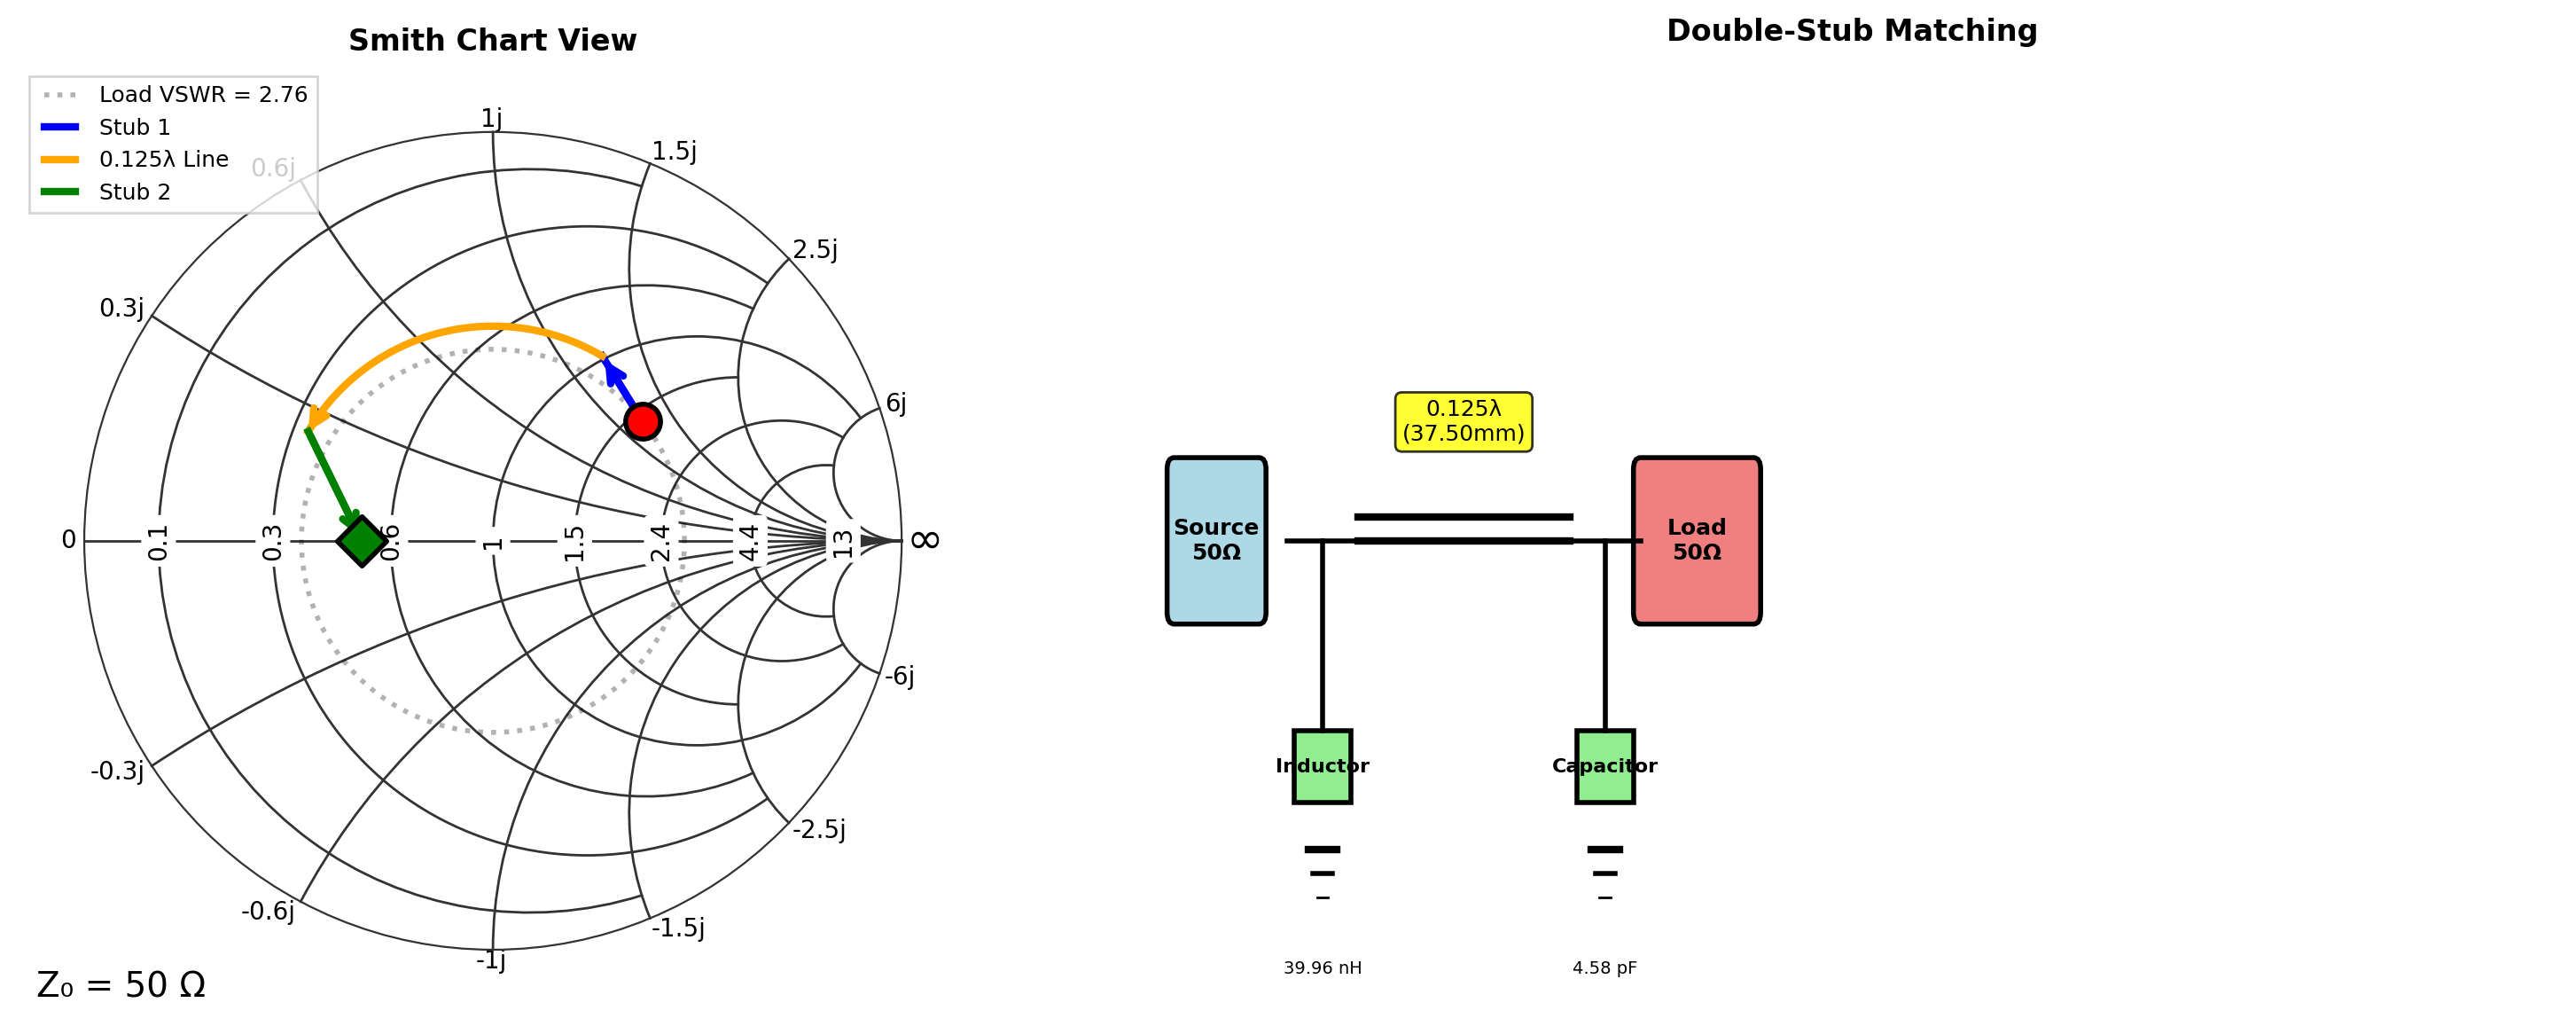

In [7]:
# Example 5: Double-stub matching
Z_load = 80 + 60j
stub_spacing = 0.125  # λ/8 spacing

print("=" * 60)
print("EXAMPLE 5: DOUBLE-STUB MATCHING")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: {Z_load:.1f} Ω")
print(f"Stub spacing: {stub_spacing}λ")
print()

# Step 1: First stub - adjust to put impedance on g=1 circle after TL
# This requires solving graphically or numerically
# For simplicity, we'll use an approximate solution

# Convert to admittance
Y_load = 1 / Z_load

# First stub adds susceptance to reach the g=1 circle after λ/8 rotation
# Target: After rotation, we want G = 1/Z0
# This is a transcendental equation - using approximate solution

# Rotate by λ/8 to see where we need to be
Z_after_spacing = utils.rotate_by_wavelength(Z_load, stub_spacing, Z0=Z0)

# We want to end on R=Z0 circle
# Solve for first stub value
# Using simplified approach: target the real axis after first stub + TL
Z_intermediate = utils.rotate_toward_real(Z_load, Z0, Z0=Z0, solution="closer")

# Calculate first stub
Y_intermediate = 1 / Z_intermediate
B_stub1 = Y_intermediate.imag - Y_load.imag
X_stub1 = -1 / B_stub1 if B_stub1 != 0 else 0

comp1_type, comp1_value, comp1_unit = reactance_to_component(X_stub1, f)

print(f"First stub (at load):")
print(f"  Susceptance: {B_stub1*1000:+.3f} mS")
print(f"  Reactance: {X_stub1:+.2f} Ω")
print(f"  Component: {comp1_type} = {comp1_value:.2f} {comp1_unit}")
print()

# After first stub
Y_after_stub1 = Y_load + 1j * B_stub1
Z_after_stub1 = 1 / Y_after_stub1

# Rotate by λ/8
Z_after_tl = utils.rotate_by_wavelength(Z_after_stub1, stub_spacing, Z0=Z0)
Y_after_tl = 1 / Z_after_tl

print(f"After spacing line ({stub_spacing}λ):")
print(f"  Impedance: {Z_after_tl:.2f} Ω")
print()

# Second stub - cancel remaining susceptance
B_stub2 = -Y_after_tl.imag
X_stub2 = -1 / B_stub2 if B_stub2 != 0 else 0

comp2_type, comp2_value, comp2_unit = reactance_to_component(X_stub2, f)

print(f"Second stub:")
print(f"  Susceptance: {B_stub2*1000:+.3f} mS")
print(f"  Reactance: {X_stub2:+.2f} Ω")
print(f"  Component: {comp2_type} = {comp2_value:.2f} {comp2_unit}")
print()

# Final
Y_final = Y_after_tl + 1j * B_stub2
Z_final = 1 / Y_final
print(f"Final impedance: {Z_final:.2f} Ω")
vswr_final = utils.calc_vswr(Z0, Z_final)
print(f"Final VSWR: {vswr_final:.3f}:1")

# Visualization
length_spacing_mm = stub_spacing * lambda_m * 1000

fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax_smith = fig.add_subplot(gs[0], projection="smith")
ax_diagram = fig.add_subplot(gs[1])

# Smith chart
vswr = utils.calc_vswr(Z0, Z_load)
ax_smith.plot_vswr(vswr, "k:", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")

# Plot path
ax_smith.plot([Z_load, Z_after_stub1], "b-", linewidth=3, arrow="end", label="Stub 1")
ax_smith.plot_rotation_path(
    Z_after_stub1, Z_after_tl, "orange", linewidth=3, arrow="end", label=f"{stub_spacing}λ Line"
)
ax_smith.plot([Z_after_tl, Z_final], "g-", linewidth=3, arrow="end", label="Stub 2")

# Mark points
ax_smith.scatter(Z_load, c="red", s=200, marker="o", edgecolors="black", linewidths=2, zorder=10)
ax_smith.scatter(Z_final, c="green", s=200, marker="D", edgecolors="black", linewidths=2, zorder=10)

ax_smith.legend(loc="upper left", fontsize=9)
ax_smith.set_title("Smith Chart View", fontsize=12, fontweight="bold")

# Block diagram
components = [
    ("Shunt", f"{comp1_type}\n{comp1_value:.2f} {comp1_unit}", "first"),
    ("TL", f"{stub_spacing}λ\n({length_spacing_mm:.2f}mm)", "middle"),
    ("Shunt", f"{comp2_type}\n{comp2_value:.2f} {comp2_unit}", "second"),
]
draw_block_diagram(ax_diagram, components, "Double-Stub Matching")

plt.tight_layout()
plt.show()